# LeNet5 using Forest Fire Dataset

# 1. Data Pre processing 

In [2]:
# Cell 1: Data Cleaning, Preprocessing, and DataLoaders

import os
import shutil
from PIL import Image, UnidentifiedImageError
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- 1. Copy and Clean the Dataset ---
# This part of the code cleans corrupted images and copies the data to a
# writable directory in Kaggle's environment.

# Define the root path for your input dataset
input_root = '/kaggle/input'

# Define the paths for your training, validation, and testing data
input_train_path = os.path.join(input_root, 'forest-fire-images/Data/Train_Data')
input_val_path = os.path.join(input_root, 'forest-fire-dataset/Forest Fire Dataset/Training')
input_test_path = os.path.join(input_root, 'forest-fire-images/Data/Test_Data')

# Define the root path for your new, writable cleaned dataset
working_root = '/kaggle/working/cleaned_dataset'
os.makedirs(working_root, exist_ok=True)

print("Starting dataset copy...")

# Define the destination paths for the copied and cleaned data
cleaned_train_data_path = os.path.join(working_root, 'Train_Data')
cleaned_val_data_path = os.path.join(working_root, 'Validation_Data')
cleaned_test_data_path = os.path.join(working_root, 'Test_Data')

# A dictionary to manage the source and destination paths for copying
paths_to_copy = {
    input_train_path: cleaned_train_data_path,
    input_val_path: cleaned_val_data_path,
    input_test_path: cleaned_test_data_path
}

# Copy the directories to the working folder
for src, dst in paths_to_copy.items():
    if os.path.exists(src):
        # Remove destination if it already exists to ensure a clean copy
        if os.path.exists(dst):
            shutil.rmtree(dst)
        shutil.copytree(src, dst)
        print(f"Copied {src} to {dst}")
    else:
        print(f"Warning: Source directory not found: {src}. Skipping.")

print("\nCopy process finished. Starting dataset cleaning on the new files...")

total_files_checked = 0
total_files_removed = 0

# Loop through each new, writable data split directory to clean it
for new_path in paths_to_copy.values():
    if not os.path.exists(new_path):
        continue
    
    print(f"\nScanning {new_path}...")
    
    # Loop through all files in the directory and its subdirectories
    for root, dirs, files in os.walk(new_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                total_files_checked += 1
                
                # Use a try-except block to check for corrupted files
                try:
                    img = Image.open(file_path)
                    img.verify() # Verify that the image is not corrupted
                    img.close()
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Corrupted file found and will be removed: {file_path}")
                    os.remove(file_path) # Permanently delete the file
                    total_files_removed += 1
                    
print("\nCleaning process finished.")
print(f"Summary: Checked {total_files_checked} files. Removed {total_files_removed} corrupted files.")


# --- 2. Data Augmentation and Preprocessing ---
# Define the transforms for the cleaned data.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# --- 3. Load Datasets and Create DataLoaders ---
print("\nLoading cleaned datasets from '/kaggle/working/cleaned_dataset'...")

# Load datasets from the new, cleaned paths
train_dataset = datasets.ImageFolder(cleaned_train_data_path, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(cleaned_val_data_path, transform=data_transforms['val_test'])
test_dataset = datasets.ImageFolder(cleaned_test_data_path, transform=data_transforms['val_test'])

# Get total number of classes and images
class_names = train_dataset.classes
total_train_images = len(train_dataset)
total_val_images = len(val_dataset)
total_test_images = len(test_dataset)

print("\nDataset Loading and Preprocessing Complete.")
print("---------------------------------")
print("Class Information:")
for cls in class_names:
    print(f"- {cls}")
print("---------------------------------")
print("Total number of images per split:")
print(f"- Training: {total_train_images} images")
print(f"- Validation: {total_val_images} images")
print(f"- Testing: {total_test_images} images")
print("---------------------------------")


# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created and ready for use.")

Starting dataset copy...
Copied /kaggle/input/forest-fire-images/Data/Train_Data to /kaggle/working/cleaned_dataset/Train_Data
Copied /kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training to /kaggle/working/cleaned_dataset/Validation_Data
Copied /kaggle/input/forest-fire-images/Data/Test_Data to /kaggle/working/cleaned_dataset/Test_Data

Copy process finished. Starting dataset cleaning on the new files...

Scanning /kaggle/working/cleaned_dataset/Train_Data...
Corrupted file found and will be removed: /kaggle/working/cleaned_dataset/Train_Data/Fire/F_89.jpg
Corrupted file found and will be removed: /kaggle/working/cleaned_dataset/Train_Data/Fire/F_941.jpg
Corrupted file found and will be removed: /kaggle/working/cleaned_dataset/Train_Data/Fire/F_854.jpg
Corrupted file found and will be removed: /kaggle/working/cleaned_dataset/Train_Data/Fire/F_851.jpg
Corrupted file found and will be removed: /kaggle/working/cleaned_dataset/Train_Data/Fire/F_59.jpg
Corrupted file found and wil

# 2. Model Training and Evalution Functions

In [3]:
# Cell 2: LeNet-5 Model and Training/Evaluation Functions

import torch.nn as nn
import torch.optim as optim
import time

class LeNet5(nn.Module):
    """
    A custom implementation of the LeNet-5 architecture for binary classification.
    """
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        
        # LeNet-5's convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # LeNet-5's fully connected (dense) layers
        # Input size for the first linear layer is 16 * 30 * 30
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 30 * 30, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def train_and_evaluate(model, train_loader, val_loader, num_epochs=10):
    """
    Trains and evaluates the model.
    
    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): The DataLoader for the training set.
        val_loader (DataLoader): The DataLoader for the validation set.
        num_epochs (int): The number of training epochs.
    
    Returns:
        The trained model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Starting training...")
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # --- Validation Phase ---
        model.eval()
        running_corrects = 0
        
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            with torch.no_grad():
                outputs = model(inputs)
                preds = torch.sigmoid(outputs) > 0.5
                running_corrects += torch.sum(preds == (labels > 0.5))

        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} | Val Accuracy: {epoch_acc:.4f}")

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    return model

# 3. Model Training and Testing 

Starting training and evaluation...
Epoch 1/10 - Train Loss: 0.2935 | Train Acc: 0.5003 | Val Loss: 0.1960 | Val Acc: 0.9382 | Test Loss: 0.5340 | Test Acc: 0.8000
Epoch 2/10 - Train Loss: 0.2003 | Train Acc: 0.5136 | Val Loss: 0.1723 | Val Acc: 0.9382 | Test Loss: 0.3224 | Test Acc: 0.8800
Epoch 3/10 - Train Loss: 0.1833 | Train Acc: 0.5064 | Val Loss: 0.1566 | Val Acc: 0.9454 | Test Loss: 0.3381 | Test Acc: 0.9000
Epoch 4/10 - Train Loss: 0.1743 | Train Acc: 0.4990 | Val Loss: 0.1681 | Val Acc: 0.9395 | Test Loss: 0.4252 | Test Acc: 0.8400
Epoch 5/10 - Train Loss: 0.1553 | Train Acc: 0.5142 | Val Loss: 0.1275 | Val Acc: 0.9651 | Test Loss: 0.3219 | Test Acc: 0.9000
Epoch 6/10 - Train Loss: 0.1704 | Train Acc: 0.5021 | Val Loss: 0.1369 | Val Acc: 0.9586 | Test Loss: 0.3042 | Test Acc: 0.9200
Epoch 8/10 - Train Loss: 0.1337 | Train Acc: 0.5038 | Val Loss: 0.1589 | Val Acc: 0.9434 | Test Loss: 0.4301 | Test Acc: 0.8400
Epoch 9/10 - Train Loss: 0.1147 | Train Acc: 0.5025 | Val Loss: 0.16

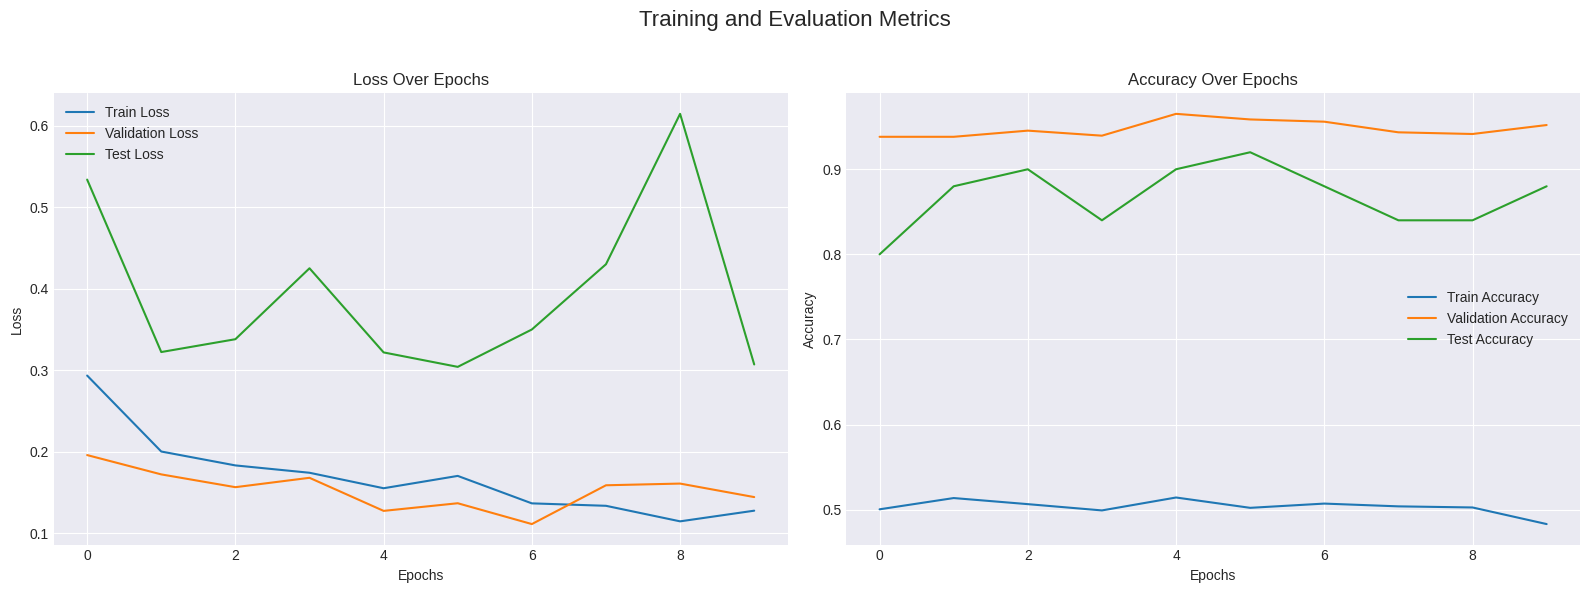

In [4]:
# Cell 3: Main Execution

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Check if data loaders have been defined from Cell 1
if 'train_loader' not in locals():
    print("Please run Cell 1 first to prepare the data loaders.")
else:
    # --- Updated Train and Evaluate Function ---
    # We redefine the function here to include test set evaluation within each epoch.
    def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10):
        """
        Trains and evaluates the model, tracking metrics for all three datasets.

        Args:
            model (nn.Module): The PyTorch model to train.
            train_loader (DataLoader): The DataLoader for the training set.
            val_loader (DataLoader): The DataLoader for the validation set.
            test_loader (DataLoader): The DataLoader for the testing set.
            num_epochs (int): The number of training epochs.
        
        Returns:
            The trained model and a history dictionary of metrics.
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Initialize history dictionary to store metrics
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'test_loss': [], 'test_acc': []
        }

        print("Starting training and evaluation...")
        start_time = time.time()

        for epoch in range(num_epochs):
            # --- Training Phase ---
            model.train()
            running_loss = 0.0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            # Calculate epoch-wise training loss and accuracy
            train_loss = running_loss / len(train_loader.dataset)
            train_preds = torch.sigmoid(model(torch.cat([inputs for inputs, labels in train_loader]).to(device))) > 0.5
            train_acc = torch.sum(train_preds.view(-1) == torch.cat([labels for inputs, labels in train_loader]).float().to(device)).item() / len(train_loader.dataset)
            
            # --- Evaluation Phase on Validation and Test Sets ---
            model.eval()
            val_corrects = 0
            test_corrects = 0
            val_loss = 0.0
            test_loss = 0.0

            with torch.no_grad():
                # Validation evaluation
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    preds = torch.sigmoid(outputs) > 0.5
                    val_corrects += torch.sum(preds == (labels > 0.5))

                # Test evaluation
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    preds = torch.sigmoid(outputs) > 0.5
                    test_corrects += torch.sum(preds == (labels > 0.5))

            val_acc = val_corrects.double() / len(val_loader.dataset)
            val_loss /= len(val_loader.dataset)
            test_acc = test_corrects.double() / len(test_loader.dataset)
            test_loss /= len(test_loader.dataset)

            # Store metrics in history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc.item())
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc.item())
            
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        time_elapsed = time.time() - start_time
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        
        return model, history

    # Instantiate the LeNet-5 model
    model = LeNet5()

    # Train and evaluate the model, and get the history
    trained_model, history = train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10)
    
    # --- Plotting the Metrics ---
    print("\nGenerating charts...")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.suptitle('Training and Evaluation Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 4. Confusion Matrix and Report

Generating confusion matrix and classification report...


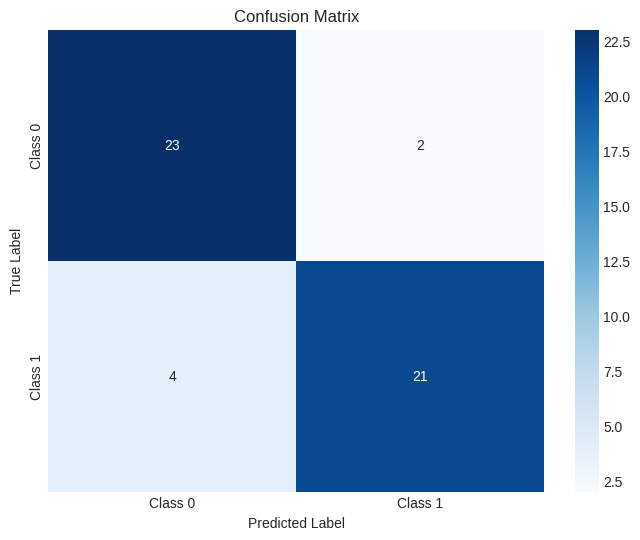


Classification Report:
              precision    recall  f1-score   support

        Fire       0.85      0.92      0.88        25
    Non_Fire       0.91      0.84      0.87        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [6]:
# Cell 4: Confusion Matrix and Classification Report

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure you've run the previous cells and the 'trained_model' is available
if 'trained_model' not in locals():
    print("Please run the previous cells to train the model and get 'trained_model'.")
else:
    print("Generating confusion matrix and classification report...")

    # Set the model to evaluation mode
    trained_model.eval()

    # Get the device from the model
    device = next(trained_model.parameters()).device

    # Initialize lists to store true labels and predicted labels
    all_labels = []
    all_preds = []

    # Get predictions for the test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = trained_model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.view(-1).cpu().tolist())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display the confusion matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Generate the classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

# 5. Model Summary

In [7]:
# Cell 5: Model Summary

from torchsummary import summary

# The torchsummary library needs a single input tensor to calculate shapes.
# We'll create a dummy tensor that matches the size of a single image.
dummy_input = torch.zeros(1, 3, 128, 128)

# Check for GPU availability and move the dummy tensor to the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dummy_input = dummy_input.to(device)

# Make sure you've run the previous cells and the 'model' is available
if 'model' not in locals():
    print("Please run the previous cells to instantiate the model.")
else:
    print("Displaying model summary:")
    summary(model, input_size=(3, 128, 128))

Displaying model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 128, 128]             456
              ReLU-2          [-1, 6, 128, 128]               0
         MaxPool2d-3            [-1, 6, 64, 64]               0
            Conv2d-4           [-1, 16, 60, 60]           2,416
              ReLU-5           [-1, 16, 60, 60]               0
         MaxPool2d-6           [-1, 16, 30, 30]               0
           Flatten-7                [-1, 14400]               0
            Linear-8                  [-1, 120]       1,728,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                    [-1, 1]              85
Total params: 1,741,241
Trainable params: 1,741,241
Non-trainable params: 0
-

# 6. Save Model

In [ ]:
# Cell 6: Save the Trained Model

import os

# Define the path where the model will be saved
model_save_path = '/kaggle/working/lenet5_forest_fire_classifier.pth'

# Make sure you've run the training cell and the 'trained_model' is available
if 'trained_model' not in locals():
    print("Please run the training cells first to get the trained model.")
else:
    print(f"Saving model to {model_save_path}...")
    torch.save(trained_model.state_dict(), model_save_path)
    print("Model saved successfully!")

    # Verify that the file exists
    if os.path.exists(model_save_path):
        print("File verification: The model file exists.")
    else:
        print("Error: The model file was not found after saving.")

# 7. Use Saved Model to Make Predictions

In [ ]:
# Cell 7: Use Saved Model to Predict on an Image from URL

import torch
import torch.nn as nn
from torchvision import transforms
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# It is essential to redefine the model architecture to load the weights correctly.
# This must match the LeNet5 class from Cell 2 exactly.
class LeNet5(nn.Module):
    """
    A custom implementation of the LeNet-5 architecture for binary classification.
    """
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        
        # LeNet-5's convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # LeNet-5's fully connected (dense) layers
        # Input size for the first linear layer is 16 * 30 * 30
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 30 * 30, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def predict_image_from_url(url, model, model_path, image_size=(128, 128)):
    """
    Downloads an image from a URL, preprocesses it, and makes a prediction
    using the loaded PyTorch model.

    Args:
        url (str): The URL of the image to predict.
        model (nn.Module): An instance of the model class.
        model_path (str): The file path to the saved model weights.
        image_size (tuple): The size to resize the image to.
    """
    try:
        # Step 1: Download the image from the URL
        print(f"Downloading image from URL: {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raises an HTTPError for bad responses (4xx or 5xx)
        image_data = BytesIO(response.content)
        img = Image.open(image_data).convert('RGB')
        
        # Step 2: Preprocess the image to match the model's input
        # Use the same transforms as the validation/test data loaders
        preprocess = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        img_tensor = preprocess(img)
        # Add a batch dimension (B, C, H, W)
        img_tensor = img_tensor.unsqueeze(0)

        # Step 3: Load the saved model weights
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        # Step 4: Make a prediction
        print("Making a prediction...")
        with torch.no_grad():
            output = model(img_tensor.to(device))
            # Apply sigmoid to get a probability
            probability = torch.sigmoid(output).item()
            prediction = 1 if probability > 0.5 else 0

        # Determine the class based on the prediction
        predicted_class = "Fire" if prediction == 1 else "No Fire"
        
        # Step 5: Display the image and prediction
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class} (Confidence: {probability:.4f})")
        plt.axis('off')
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Example Usage ---
# Make sure the 'lenet5_forest_fire_classifier.pth' file exists from Cell 6
model_path = '/kaggle/working/lenet5_forest_fire_classifier.pth'
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found. Please run Cell 6 first.")
else:
    # Instantiate the model
    model = LeNet5()

    # Example URL for a fire image
    fire_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSL0ixEpaLOp6LiJ-1u22pFBs120nGxSGMVKA&s'
    
    # Example URL for a non-fire image
    non_fire_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4isV1Zw_95jC_Z4xRdWhkCl8QHWB_D3OJtQ&s'

    # Call the prediction function with one of the URLs
    predict_image_from_url(fire_url, model, model_path)
    # predict_image_from_url(non_fire_url, model, model_path)